# Feature Engineering

## Генерация признаков

Для иллюстрации будут использованны примеры из книги "[Real-World Machine Learning](https://www.manning.com/books/real-world-machine-learning)" из открытого репозиторя:
https://github.com/brinkar/real-world-machine-learning

И датасет Titanic:
http://campus.lakeforest.edu/frank/FILES/MLFfiles/Bio150/Titanic/TitanicMETA.pdf

В отличие от датасетов с которыми мы работали до сих пор это просто список пассажиров судна. Данные в нем не предобработанны и в сыром виде не могут быть использованны для обучения модели.



In [1]:
! wget https://raw.githubusercontent.com/brinkar/real-world-machine-learning/master/data/titanic.csv

import pandas
data = pandas.read_csv("titanic.csv")
data[:5]

--2021-02-19 06:25:49--  https://raw.githubusercontent.com/brinkar/real-world-machine-learning/master/data/titanic.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61194 (60K) [text/plain]
Saving to: ‘titanic.csv’

titanic.csv         100%[===================>]  59.76K  --.-KB/s    in 0.008s  

2021-02-19 06:25:50 (7.28 MB/s) - ‘titanic.csv’ saved [61194/61194]



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


1. Часть полей можно исключить (имя)

2. Часть преобразовать в числа (пол, порт посадки ...)
https://github.com/brinkar/real-world-machine-learning/blob/master/Chapter%203%20-%20Modeling%20and%20prediction.ipynb

3. Непрерывные данные нормировать (здесь вместо этого берется квадратный корень из цены)

4. На основании некоторых создать новые более полезные для модели (Номер кабины):
cabin_data = array(["C65", "", "E36", "C54", "B57 B59 B63 B66"])
->
[['C', 65, 1], ['X', -1, 0], ['E', 36, 1], ['C', 54, 1], ['B', 57, 4]]

https://github.com/brinkar/real-world-machine-learning/blob/master/Chapter%202%20-%20Data%20Processing.ipynb


In [3]:
import numpy as np
# The categorical-to-numerical function from chapter 2
# Changed to automatically add column names
def cat_to_num(data):
  categories = set(data)
  features = {}
  for cat in categories:
      binary = (data == cat)
      if len(set(binary)) == 1:
        # Ignore features where all values equal 
        continue
      new_key = f'{data.name}={cat}'

      features[new_key] = binary.astype("int")
  return pandas.DataFrame(features)

def cabin_features(data):
    features = []
    for cabin in data:
        cabins = str(cabin).split(" ")
        n_cabins = len(cabins)
        # First char is the cabin_char
        try:
            cabin_char = cabins[0][0]
        except IndexError:
            cabin_char = "X"
            n_cabins = 0
        # The rest is the cabin number
        try:
            cabin_num = int(cabins[0][1:]) 
        except:
            cabin_num = -1
        # Add 3 features for each passanger
        features.append( [cabin_char, cabin_num, n_cabins] )
    features=np.array(features)
    dic_of_features =  {
        #'Cabin_char' : features[:,0],
        'Cabin_num' : features[:,1].astype("int"),
        'N_cabins' : features[:,2].astype("int"),
         }
    out = pandas.DataFrame(dic_of_features)
    char_column = pandas.DataFrame({'Cabin_char' : features[:,0]})
    cabin_ch = cat_to_num(char_column['Cabin_char'])
    return out.join(cabin_ch)

def prepare_data(data):
    """Takes a dataframe of raw data and returns ML model features
    """
    
    # Initially, we build a model only on the available numerical values
    features = data.drop(["PassengerId", "Survived", "Fare", "Name", "Sex", "Ticket", "Cabin", "Embarked"], axis=1)
    
    # Setting missing age values to -1
    features["Age"] = data["Age"].fillna(-1)
    
    # Adding the sqrt of the fare feature
    features["sqrt_Fare"] = np.sqrt(data["Fare"])
    
    # Adding gender categorical value
    features = features.join( cat_to_num(data['Sex']) )
    
    # Adding Embarked categorical value
    features = features.join( cat_to_num(data['Embarked']) )

    # Split cabin
    features = features.join( cabin_features(data['Cabin']) )
    
    return features

features = prepare_data(data)
features[:5]

,Pclass,Age,SibSp,Parch,sqrt_Fare,Sex=female,Sex=male,Embarked=S,Embarked=Q,Embarked=C,Cabin_num,N_cabins,Cabin_char=D,Cabin_char=G,Cabin_char=A,Cabin_char=F,Cabin_char=B,Cabin_char=E,Cabin_char=C,Cabin_char=T,Cabin_char=n
0,3,22.0,1,0,2.692582,0,1,1,0,0,-1,1,0,0,0,0,0,0,0,0,1
1,1,38.0,1,0,8.442944,1,0,0,0,1,85,1,0,0,0,0,0,0,1,0,0
2,3,26.0,0,0,2.815138,1,0,1,0,0,-1,1,0,0,0,0,0,0,0,0,1
3,1,35.0,1,0,7.286975,1,0,1,0,0,123,1,0,0,0,0,0,0,1,0,0
4,3,35.0,0,0,2.837252,0,1,1,0,0,-1,1,0,0,0,0,0,0,0,0,1


Теперь модель обучать:

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# We make a 80/20% train/test split of the data
features = prepare_data(data)
X_train, X_test, y_train, y_test = train_test_split(features, data["Survived"], test_size=0.2, random_state=33)

model = LogisticRegression(max_iter=1000)
model.fit(X_train,y_train)

# Make predictions
print(model.score(X_test,y_test))

0.7877094972067039


## Примеры данных которые нецелесообразноо отправлять в модель в сыром виде:

### IP адрес: 
xxx.xxx.xxx.xxx -> регион, провайдер

### Координаты атомов:
AlphaFold
https://yakovlev.me/para-slov-za-alphafold2/

"как вообще математически можно выразить структуру белка. До того мы постоянно неявно подразумевали, что это координаты атомов (всех, каркасных, Cα или каких-то ещё), но на практике это очень неудачное представление, поскольку оно не единственное. Мы обычно считаем, что предсказание работает как некоторая детерминированная функция: принимает на вход последовательность и всегда возвращает один единственный ответ. Но какой из бесконечного набора координат "канонический"?



"... инвариантом структуры является матрица (таблица) всех попарных расстояний между атомами. "



# Отбор признаков

В прошлых лекциях вы познакомились с тем, что такое признаки. Сегодня мы попытаемся научиться отделять полезные признаки от бесполезных, а также понижать размерность пространства признаков.

## Зачем отбирать признаки?


<img src="http://edunet.kea.su/repo/src/L04_Feature_Engineering/img/L04_features.png" alt="alttext" width=760/>

*Во-первых*, признаков может быть слишком много, больше чем нужно. Это может возникнуть в ситуациях, когда используется вся имеющаяся на данный момент информация, потому что неизвестно, какая её часть может понадобиться, а какая — нет. В таких случаях можно повысить качество решения задачи, выбирая только действительно важные признаки. Существует другой подход: можно сформировать новые признаки на основе старых, таким образом признаков станет меньше, но их информативность сохранится.

*Во-вторых*, существуют признаки, из-за которых при решении задачи возникает много проблем. Это шумовые признаки — признаки, которые не связаны с целевой переменной и никак не относятся к решаемой задаче. К сожалению, не всегда можно понять по обучающей выборке, что в ней присутствуют такие признаки.
Полезно рассмотреть несколько примеров присутствия шумовых признаков в данных. Пусть в выборку добавляют 1000 признаков. Значения каждого признака генерируются из стандартного нормального распределения. Понятно, что эти признаки бесполезны, они никак не помогут решить задачу. Но, поскольку их много, может так оказаться (из соображений теории вероятностей), что один из них коррелирует с целевой переменной. При этом он будет коррелировать только на обучающей выборке, а на контрольной выборке корреляции наблюдаться не будет, поскольку признак абсолютно случайный. Однако внутри модели этот признак может быть учтён как важный и иметь какой-то вес. Получается, что модель зависит от признака, который никак не помогает решить задачу. Из-за этого качество модели и ее обобщающая способность окажутся ниже, чем хотелось бы. 

В более общем случае можно говорить, что в многоразмерном пространстве почти всегда можно найти корреляции. См. картинку.


<img src="http://edunet.kea.su/repo/src/L04_Feature_Engineering/img/L04_correlations.png" alt="alttext" width=600/>


Больше подобных примеров можно найти на https://www.wnycstudios.org/podcasts/otm/articles/spurious-correlations.

*В-третьих*, перед нами может стоять задача ускорения модели. Дело в том, что чем больше признаков, тем более сложная модель получается, и тем больше времени необходимо, чтобы построить прогноз. Существуют задачи, в которых прогнозы нужно строить очень быстро, например, выдача рекомендаций товаров на сайте интернет-магазина. Пользователь что-то ищет, нажимает на ссылку в поисковой выдаче и переходит на страницу интересующего его товара. На этой странице есть поле, в котором показываются рекомендации к этому товару, например похожие товары, которые должна выдавать модель. Важно, чтобы она выдавала рекомендации очень быстро, страница не должна долго загружаться, чтобы пользователь не подумал, что с сайтом что-то не так, и не ушел к конкуренту. В этом случае необходимо, чтобы модель была очень быстрой, и один из подходов к ускорению модели — это отбор признаков, которых достаточно, чтобы прогнозы были хорошими.

## Одномерный отбор признаков

Самый простой подход к отбору признаков — это одномерный подход. В нём оценивается связь каждого признака с целевой переменной, например, измеряется корреляция. Такой подход — довольно простой, он не учитывает сложные закономерности, в нём все признаки считаются независимыми, тогда как в машинном обучении модели учитывают взаимное влияние признаков, их пар или даже более сложные действия на целевую переменную. Этот подход не всегда хорош, но иногда его можно использовать, чтобы ранжировать признаки, найти наиболее мощные среди них.

### Формализация задачи
Пусть у нас есть N объектов с K признаками и для каждого объекта задана целевая переменная или ответ. Обозначим  матрицу объектов-признаков через $X \in \mathbf{R}^{N x M} $, а вектор ответов через Y. Для удобства введем следующие дополнительные обозначения:

* $\overline{X}_j$- среднее значение признака j по всей выборке
* $\overline{Y}$- среднее значение целевой переменной на всей выборке

Задача — оценить предсказательную силу (информативность) каждого признака, то есть насколько хорошо по данному признаку можно предсказывать целевую переменную. Данные оцененной информативности можно использовать, чтобы отобрать k лучших признаков или признаки, у которых значение информативности больше порога (например, некоторой квантили распределения информативности).

### Корреляция

Один из самых простых методов измерения связи между признаком и ответами — это корреляция. Корреля́ция (от лат. correlatio «соотношение»), или корреляцио́нная зави́симость — статистическая взаимосвязь двух или более случайных величин (либо величин, которые можно с некоторой допустимой степенью точности считать таковыми). При этом изменения значений одной или нескольких из этих величин сопутствуют систематическому изменению значений другой или других величин.

Коэффициент корреляции R определяется формулой:

$ R = \frac{\sum_{i=1}^{N} (X_{ij} - \overline{X}_j)(Y_{i} - \overline{Y})} {\sqrt{ \sum_{i=1}^{N}(X_{ij} - \overline{X}_j)^2\sum_{i=1}^{N} (Y_{i} - \overline{Y})^2}} $


Чем больше по модулю корреляция между признаком и целевой переменной, тем более информативным является данный признак. При этом она максимальна по модулю (Rj = ±1), если между признаком и целевой переменной есть **линейная связь**, то есть если целевую переменную можно строго линейно выразить через значение признака. Это означает, что корреляция измеряет только линейную информативность, то есть способность признака линейно предсказывать целевую переменную. Вообще говоря, корреляция рассчитана на вещественные признаки и вещественные ответы. Тем не менее, её можно использовать в случае, если признаки и ответы бинарные (имеет смысл кодировать бинарный признак с помощью значений ±1).

BTW: не является истинной мерой расстояния, так как для нее не выполняется неравенство треугольника.

In [5]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from scipy import stats

correlations = []
for column in features:
  r , p_value = stats.pearsonr(features[column], data["Survived"])
  correlations.append((column,r))

correlations.sort(key=lambda tup: abs(tup[1]),reverse=True)
for name, r in correlations:
  print(f'{name} : {r:.3f} ')
  

Sex=female : 0.543 
Sex=male : -0.543 
Pclass : -0.338 
Cabin_char=n : -0.317 
sqrt_Fare : 0.313 
Cabin_num : 0.238 
Cabin_char=B : 0.175 
Embarked=C : 0.168 
Embarked=S : -0.156 
Cabin_char=D : 0.151 
Cabin_char=E : 0.145 
Cabin_char=C : 0.115 
Parch : 0.082 
N_cabins : 0.073 
Cabin_char=F : 0.058 
SibSp : -0.035 
Cabin_char=T : -0.026 
Cabin_char=A : 0.022 
Cabin_char=G : 0.016 
Age : 0.012 
Embarked=Q : 0.004 


### AUC-ROC


Пусть решается задача бинарной классификации, и необходимо оценить важность признака j для решения именно этой задачи. В этом случае можно попробовать построить классификатор, который использует лишь этот один признак j, и оценить его качество. Например, можно рассмотреть очень простой классификатор, который берёт значение признака j на объекте, сравнивает его с порогом t, и если значение меньше этого порога, то он относит объект к первому классу, если же меньше порога — то к другому, нулевому или минус первому, в зависимости от того, как мы его обозначили. Далее, поскольку этот классификатор зависит от порога t, то его качество можно измерить с помощью таких метрик, как площадь под ROC-кривой или Precision-Recall кривой, а затем по данной площади отсортировать все признаки и выбирать лучшие.




### Проблемы одномерного отбора признаков


<img src="http://edunet.kea.su/repo/src/L04_Feature_Engineering/img/L04_multidim.png" alt="alttext" width=600/>


У подхода, при котором важности всех признаков оцениваются по отдельности, есть свои недостатки. На левом рисунке изображена двумерная выборка, для которой необходимо решить задачу классификации. Если спроецировать данную выборку на ось абсцисс, то она будет разделима, хотя и будут присутствовать ошибки. Если же спроецировать данную выборку на ось ординат, то все объекты разных классов перемешаются, и выборка будет неразделима. В этом случае при использовании любого метода одномерного оценивания информативности первый признак будет информативен, а второй — совершенно неинформативен. Тем не менее, видно, что если использовать эти признаки одновременно, то классы будут разделимы идеально. На самом деле, второй признак важен, но он важен только в совокупности с первым, и методы одномерного оценивания информативности не способны это определить. На рисунке справа показана выборка, на которой одномерные методы оценки информативности работают ещё хуже. В этом случае, если спроецировать выборку на ось абсцисс или ординат, то объекты классов перемешаются, и в обоих случаях данные будут совершенно неразделимы. И, согласно любому из описанных методов, оба признака неинформативны. Тем не менее, если использовать их одновременно, то, например, решающее дерево может идеально решить данную задачу классификации.

Пример: Влияние роста и веса при предсказании вероятности сердечного заболевания. Избыточный вес может являться важным фактором, но оценить является ли он избыточным или нормальным можно только зная рост пациента.

## Жадный отбор признаков


Жадные методы отбора признаков, по сути своей, являются надстройками над методами обучения моделей. Они перебирают различные подмножества признаков и выбирают то из них, которое дает наилучшее качество определённой модели машинного обучения.
Данный процесс устроен следующим образом. Обучение модели считается черным ящиком, который на вход принимает информацию о том, какие из его признаков можно использовать при обучении модели, обучает модель, и дальше каким-то методом оценивается качество такой модели, например, по отложенной выборке или кросс-валидации. Таким образом, задача, которую необходимо решить — это оптимизация функционала качества модели по подмножеству признаков.

### Полный перебор


<img src="http://edunet.kea.su/repo/src/L04_Feature_Engineering/img/L04_graphic-full.png" alt="alttext" width=600/>


Самый простой способ решения данной задачи — это полный перебор всех подмножеств признаков и оценивание качества на каждом подмножестве. Итоговое подмножество — то, на котором качество модели наилучшее. Этот перебор можно структурировать и перебирать подмножества последовательно: сначала те, которые имеют мощность 1 (наборы из 1 признака), потом наборы мощности 2, и так далее. Это подход очень хороший, он найдет оптимальное подмножество признаков, но при этом очень сложный, поскольку всего таких подмножеств $2^d$, где d — число признаков. Если признаков много — сотни или тысячи, то такой перебор невозможен: он займет слишком много времени, возможно, сотни лет или больше. Поэтому такой метод подходит либо при небольшом количестве признаков, либо если известно, что информативных признаков очень мало, единицы.


### Жадное добавление


<img src="http://edunet.kea.su/repo/src/L04_Feature_Engineering/img/L04_graphic-greedy.png" alt="alttext" width=600/>


Если же признаков много и известно, что многие из них информативны, то нужно применять жадную стратегию. Жадная стратегия используется всегда, когда полный перебор не подходит для решения задачи. Например, может оказаться неплохой стратегия жадного наращивания (жадного добавления). Сначала находится один признак, который дает наилучшее качество модели (наименьшую ошибку Q):

$i_1 = argmin Q(i)$. 

Тогда множество, состоящее из этого признака:

$J_1 = {i_1}$

Дальше к этому множеству добавляется еще один признак так, чтобы как можно сильнее уменьшить ошибку модели:

$i_2 =argminQ(i_1,i)$, $J_2 ={i_1,i_2}$.

Далее каждый раз добавляется по одному признаку, образуются множества J3 , J4 , . . . . Если в какой-то момент невозможно добавить новый признак так, чтобы уменьшить ошибку, процедура останавливается. Жадность процедуры заключается в том, что как только какой-то признак попадает в оптимальное множество, его нельзя оттуда удалить.




In [6]:
#https://scikit-learn.org/stable/modules/feature_selection.html
#https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py

#http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/#example-5-sequential-feature-selection-for-regression
import pandas as pd
from mlxtend.feature_selection import SequentialFeatureSelector 
sfs = SequentialFeatureSelector(LogisticRegression(max_iter=1000),k_features = 8, cv=5)
sfs.fit(X_train,y_train)

pd.DataFrame.from_dict(sfs.get_metric_dict()).T


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(5,)","[0.8391608391608392, 0.7272727272727273, 0.802...",0.785118,"(Sex=female,)",0.047054,0.0366096,0.0183048
2,"(2, 5)","[0.8391608391608392, 0.7342657342657343, 0.809...",0.787925,"(SibSp, Sex=female)",0.0452623,0.0352156,0.0176078
3,"(0, 2, 5)","[0.8531468531468531, 0.7342657342657343, 0.809...",0.794947,"(Pclass, SibSp, Sex=female)",0.0493426,0.0383902,0.0191951
4,"(0, 2, 5, 8)","[0.8531468531468531, 0.7482517482517482, 0.809...",0.797745,"(Pclass, SibSp, Sex=female, Embarked=Q)",0.0438815,0.0341413,0.0170707
5,"(0, 2, 5, 8, 15)","[0.8531468531468531, 0.7482517482517482, 0.809...",0.797745,"(Pclass, SibSp, Sex=female, Embarked=Q, Cabin_...",0.0438815,0.0341413,0.0170707
6,"(0, 2, 5, 6, 8, 15)","[0.8531468531468531, 0.7482517482517482, 0.809...",0.797745,"(Pclass, SibSp, Sex=female, Sex=male, Embarked...",0.0438815,0.0341413,0.0170707
7,"(0, 2, 5, 6, 8, 15, 19)","[0.8531468531468531, 0.7482517482517482, 0.809...",0.797745,"(Pclass, SibSp, Sex=female, Sex=male, Embarked...",0.0438815,0.0341413,0.0170707
8,"(0, 2, 5, 6, 8, 15, 17, 19)","[0.8391608391608392, 0.7552447552447552, 0.809...",0.796346,"(Pclass, SibSp, Sex=female, Sex=male, Embarked...",0.0355306,0.027644,0.013822


### ADD-DEL


<img src="http://edunet.kea.su/repo/src/L04_Feature_Engineering/img/L04_graphic-non-greedy.png" width=600/>


Описанный выше подход довольно быстрый: в нем столько итераций, сколько признаков в выборке. Но при этом он слишком жадный, перебирается слишком мало вариантов и мы можем оказаться в плохой локальной точке. Процедуру можно усложнить. Один из подходов к усложнению — это алгоритм ADD-DEL, который не только добавляет, но и удаляет признаки из оптимального множества. Алгоритм начинается с процедуры жадного добавления. Множество признаков наращивается до тех пор, пока получается уменьшить ошибку, затем признаки жадно удаляются из подмножества, то есть перебираются все возможные варианты удаления признака, оценивается ошибка и удаляется тот признак, который приводит к наибольшему уменьшению ошибки на выборке. Эта процедура повторяет добавление и удаление признаков до тех пор, пока уменьшается ошибка. Алгоритм ADD-DEL всё еще жадный, но при этом он менее жадный, чем предыдущий, поскольку *может исправлять ошибки*, сделанные в начале перебора: если вначале был добавлен неинформативный признак, то на этапе удаления от него можно избавиться.



<img src="http://edunet.kea.su/repo/src/L04_Feature_Engineering/img/L04_graphic-add-del.png" style="height: 470px;">




In [7]:
#http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/#example-5-sequential-feature-selection-for-regression
 
sffs = SequentialFeatureSelector(
           LogisticRegression(max_iter=1000),
           k_features = 7,
           forward=True, 
           floating=True, 
           verbose=0,
           scoring='accuracy',
           cv=0)

sffs.fit(X_train.values,y_train)
pd.DataFrame.from_dict(sffs.get_metric_dict()).T

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(5,)",[0.7851123595505618],0.785112,"(5,)",NaN,0,NaN
2,"(2, 5)",[0.7879213483146067],0.787921,"(2, 5)",NaN,0,NaN
3,"(0, 2, 5)",[0.797752808988764],0.797753,"(0, 2, 5)",NaN,0,NaN
4,"(0, 2, 3, 5)",[0.797752808988764],0.797753,"(0, 2, 3, 5)",NaN,0,NaN
5,"(0, 2, 3, 5, 17)",[0.7991573033707865],0.799157,"(0, 2, 3, 5, 17)",NaN,0,NaN
6,"(0, 2, 3, 5, 6, 17)",[0.7991573033707865],0.799157,"(0, 2, 3, 5, 6, 17)",NaN,0,NaN
7,"(0, 2, 3, 5, 6, 11, 17)",[0.800561797752809],0.800562,"(0, 2, 3, 5, 6, 11, 17)",NaN,0,NaN


## Отбор признаков на основе моделей

### Использование весов признаков

Во многих моделях (eg линейных) перед признаками стоят веса. Если признаки масштабированы, то веса при признаках можно интерпретировать как информативности: чем больше по модулю вес при признаке j, тем больший вклад этот признак вносит в ответ модели. Однако если признаки не масштабированы, то так использовать веса уже нельзя. Например, если есть два признака, и один по масштабу в 1000 раз меньше другого, то вес первого признака может быть очень большим, только чтобы признаки были одинаковыми по масштабу.
Если необходимо обнулить как можно больше весов, чтобы линейная модель учитывала только те признаки, которые наиболее важны для нее, можно использовать L1-регуляризацию. Чем больше коэффициент при L1-регуляризаторе, тем меньше признаков будет использовать линейная модель.

Рассмотрим это на примере Линейного классификатора который мы конструировали на 2-м занятии.

<img src ="http://edunet.kea.su/repo/src/L04_Feature_Engineering/img/
L04_skalyar.png" width="800">

In [8]:
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train,y_train)

for i, w in enumerate(lr.coef_[0]):
  print(X_train.columns[i],w)

Pclass -0.634850772486092
Age -0.024046241407651207
SibSp -0.33515634596319743
Parch -0.14161339341714974
sqrt_Fare 0.16861813992798505
Sex=female 1.3405442039394777
Sex=male -1.3283950111150615
Embarked=S -0.12082219794490275
Embarked=Q -0.24671070747532903
Embarked=C 0.2338809297708468
Cabin_num -0.006018793106407049
N_cabins -0.24890010025757237
Cabin_char=D 0.3576893912144663
Cabin_char=G -0.6641320594872979
Cabin_char=A 0.017447355618295312
Cabin_char=F 0.5289092212043376
Cabin_char=B 0.14167389341980166
Cabin_char=E 0.7870169813929003
Cabin_char=C -0.34437944245671337
Cabin_char=T -0.31867837162335705
Cabin_char=n -0.4933977764581999


## Задача понижении размерности


## PCA (Метод главных компонент)


<img src="http://edunet.kea.su/repo/src/L04_Feature_Engineering/img/L04_PCA-demonstrative.png" width=500/>

<img src="http://edunet.kea.su/repo/src/L04_Feature_Engineering/img/PCA-main.png" width=800/>

### Отображение в пространство меньшей размерности. постановка задачи

Метод главных компонент (англ. principal component analysis, PCA) — один из основных способов уменьшить размерность данных, потеряв наименьшее количество информации. Изобретён Карлом Пирсоном в 1901 году.

Существует несколько способов сформулировать задачу метода главных компонент:

* через максимизацию дисперсии;
* через аппроксимацию данных линейными многообразиями меньшей размерности;
* через приближение матрицы матрицы с рангом k;
* через построения для данной многомерной случайной величины ортогонального преобразования координат, в результате которого корреляции между отдельными координатами обратятся в нуль.



<img src="http://edunet.kea.su/repo/src/L04_Feature_Engineering/img/L04_lec-1.png" width=850/>



Красота метода PCA заключается в том, что такие отличные постановки задачи из разных областей математики сводятся к одному и тому же решению. Рассмотрим некоторые из них.

#### Метод главных компонент как способ проекции данных на гиперплоскость

Пусть имеется выборка, изображенная на рисунке ниже, и её необходимо спроецировать на некоторую прямую. В этом случае прямая будет тем лучше, чем меньше будет ошибка проецирования суммы по всей выборке расстояний от объекта до его проекции на эту прямую. Чем меньше эти расстояния, тем лучше прямая приближает данные, тем меньше будет ошибка и тем больше информации сохраняется. В идеальном случае прямая должна проходить через все объекты выборки, но в рассматриваемой ситуации это невозможно.

В общем случае, когда признаков много, выборка проецируется на гиперплоскость. Из аналитической геометрии известно, что есть два способа задания гиперплоскости. Первый — с помощью вектора нормали, он использовался в линейных методах. Второй — с помощью направляющих векторов. Пусть в исходном пространстве размерности D строится гиперплоскость размерности D − 1, тогда, если выбрать на этой плоскости D линейно независимых векторов, то они будут однозначно задавать эту гиперплоскость. Если направляющие векторы составить в матрицу W, так что каждый столбец этой матрицы — это один направляющий вектор, то проекция точки $x_i$ на данную гиперплоскость будет вычисляться по формуле $ x_i ∗ W $. Тогда для того, чтобы уменьшить ошибку проецирования на гиперплоскость, необходимо минимизировать следующее выражение:

$ \sum_{i=1}^l \lVert x_i - x_i * W \rVert^2 \to \min_W $


<img src="http://edunet.kea.su/repo/src/L04_Feature_Engineering/img/L04_lec-4.png" width=650/>



#### Максимизация дисперсии выборки после понижения размерности


Иной взгляд на метод главных компонент заключается в следующем: пусть имеется выборка, показанная на рисунке ниже, и требуется выбрать прямую, на которую можно будет эту выборку, максимизировав при этом дисперсию спроецированных данных. Синяя прямая лучше подходит для решения данной задачи, поскольку при проецировании на нее сохраняется наибольший разброс.
И действтительно, чем больше дисперсия выборки после проецирования на прямую, тем больше сохраняется информации. Для данного случая этот критерий хорошо подходит: дисперсия выборки после проецирования на синюю прямую будет гораздо больше, чем после проецирования на красную прямую.


<img src="http://edunet.kea.su/repo/src/L04_Feature_Engineering/img/L04_lec-6.png" width=700/>



Формально дисперсию выборки после проецирования можно записать следующим образом:

$ \sum_{j=1}^d w_{j}^T X^T X w_{j} \to \max_{W}$

Чем больше значение этой суммы, тем больше оказывается дисперсия выборки после проецирования на гиперплоскость, которая задается матрицей весов W. Таким образом, это выражение нужно максимизировать, чтобы сохранить как можно больше информации.


<img src="http://edunet.kea.su/repo/src/L04_Feature_Engineering/img/L04_lec-8.png" width=480/>



Обратим внимание на то что выборка центрированна:

<img src="http://edunet.kea.su/repo/src/L04_Feature_Engineering/img/L04_covariation.png" >

### PCA Решение

#### Вывод решения

<img src="http://edunet.kea.su/repo/src/L04_Feature_Engineering/img/L04_lec-10.png" >


<img src="http://edunet.kea.su/repo/src/L04_Feature_Engineering/img/L04_first_component_1.png" >
<img src="http://edunet.kea.su/repo/src/L04_Feature_Engineering/img/L04_first_component_2.png" >
<img src="http://edunet.kea.su/repo/src/L04_Feature_Engineering/img/L04_first_component_3.png" >




Ранее была описана формулировка задачи метода главных компонент, теперь необходимо её решить. Одна из постановок задачи метода главных компонент — это максимизация дисперсии:

$ 
\begin{cases} 
\sum_{j=1}^d w_{j}^T X^T X w_{j} \to \max_{W} \\ 
W^T W = I
\end{cases}
$


Второе условие здесь приведено для обеспечения единственности решения.

Это является задачей оптимизации. Можно попытаться найти ее решение. (Если вы не знакомы с математическим анализом и далее ничего не поймете, то ничего страшного).

В первой строке записана дисперсия после проецирования, а во второй — ограничение, обеспечивающее наличие единственного решения.

В методе главных компонент есть один нюанс: выражение, через которое записана дисперсия, будет означать именно дисперсию выборки только в том случае, если матрица объекты-признаки центрирована (среднее каждого признака равно нулю). Далее считается, что выборка центрирована, и среднее из каждого столбца в матрице объекты-признаки уже вычли.

Итак, чтобы разобраться, как устроено решение этой задачи, необходимо сначала рассмотреть простой частный случай: требуется найти ровно одну компоненту, на которую проецируется вся выборка, так, чтобы дисперсия после проецирования была максимальной:

$ 
\begin{cases} 
w_{1}^T X^T X w_{1} \to \max_{w_1} \\ 
w_1^T w_1 = 1
\end{cases}
$

Для решения подобных задач условной оптимизации необходимо выписать лагранжиан:

....

После преобразований получается следующее выражение:

$X^T X w_1 = \lambda w_1$

Из него следует, что $w_1$ — это собственный вектор матрицы $X^T X$, а число $ \lambda $ является собственным значением, соответствующим этому вектору. Домножим слева полученное выражение на $w_1^T$. так-как $w_1^T w_1 = 1$, то $ w_{1}^T X^T X w_{1} = \lambda $, что говорит нам о том, что дисперсия выборки после проецирования будет равна собственному значению, соответствующему выбранному собственному вектору.

Итак, в методе главных компонент первая компонента — это собственный вектор матрицы $X^T X$, который соответствует максимальному собственному значению этой матрицы. Стоит обратить внимание, что $X^T X$ — это матрица ковариации, то есть именно та матрица, которая характеризует дисперсию выборки.



<img src="http://edunet.kea.su/repo/src/L04_Feature_Engineering/img/L04_first_component_4.png" width=300/>

Визуально это выглядит следующим образом: есть облако точек (рисунок 3.8), и необходимо выбрать именно то направление, при проецировании на которое сохраняется как можно больше дисперсии. Это направление и будет задаваться первым собственным вектором матрицы ковариации.


Итог:


## $XX^{T} = \lambda W$


Пример вычисления PCA на Python:
https://cs231n.github.io/neural-networks-2/#datapre

#### Остаточная дисперсия и производные метрики

На практике хочется как-то измерять значимость каждой компоненты. Для этого существует понятие остаточной дисперсии (explained variance).


<img src="http://edunet.kea.su/repo/src/L04_Feature_Engineering/img/L04_explained-variance.png" width=700/>



### Практика: Ковариационные матрицы

Итак, давайте для начала подробнее познакомимся с понятием ковариционной матрицы.

<img src="http://edunet.kea.su/repo/src/L04_Feature_Engineering/img/L04_gaussian_probability.png" width=600/>


<img src="http://edunet.kea.su/repo/src/L04_Feature_Engineering/img/L04_covariance_matrix.png" width=600/>




In [ ]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import sklearn as sklearn
import matplotlib.patches as mpatches
matplotlib.style.use('ggplot')
%matplotlib inline

In [ ]:
# function for plotting principal components
def plot_principal_components(data, model, scatter=True, legend=True):
    W_pca = model.components_
    if scatter:
        plt.scatter(data[:,0], data[:,1])
    plt.plot(data[:,0], -(W_pca[0,0]/W_pca[0,1])*data[:,0], color="c")
    plt.plot(data[:,0], -(W_pca[1,0]/W_pca[1,1])*data[:,0], color="c")
    if legend:
        c_patch = mpatches.Patch(color='c', label='Principal components')
        plt.legend(handles=[c_patch], loc='lower right')
    # сделаем графики красивыми:
    plt.axis('equal')
    limits = [np.minimum(np.amin(data[:,0]), np.amin(data[:,1]))-0.5,
              np.maximum(np.amax(data[:,0]), np.amax(data[:,1]))+0.5]
    plt.xlim(limits[0],limits[1])
    plt.ylim(limits[0],limits[1])
    plt.draw()

# function for vector plotting
def plot_components_vector(ax, data, vector, color, label="", delta=0.5):
    limits_x = [np.min(data[:,0])-delta, np.max(data[:,0])+delta]
    limits_y = [np.min(data[:,1])-delta, np.max(data[:,1])+delta]
    
    if np.fabs(vector[1]) > 1e-5:
        if np.fabs(vector[0]) > 1e-5:
            x = np.arange(*limits_x, 0.1)
            y = x * vector[1]/vector[0]
        else:
            y = np.arange(*limits_y, 0.1)
            x = np.full_like(y, 0)
    else:
        x = np.arange(*limits_x, 0.1)
        y = np.full_like(x, 0)
        
    ax.plot(x, y, color=color, label=label)
    # ax.set_xlim(*limits_x)
    # ax.set_ylim(*limits_y)

Для того, чтобы семлировать многоразмерное нормальное распределение, можно использовать функцию

```python
np.random.multivariate_normal(mu, covariance_matrix, size=500)
```

* mu - вектор средних значений (центр колокола);
* covariance_matrix - матрица ковариации;
* size - размер семлированной выборки.

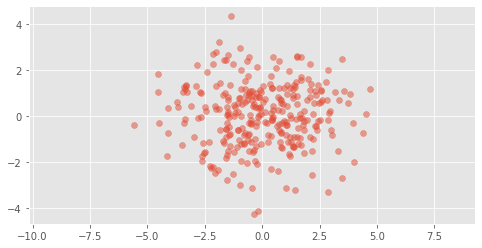

In [ ]:
# let's sample data from multivariate normal distribution with covaraince matrix C 


fig, ax = plt.subplots(1, 1 , figsize = (8, 4))

mu = np.zeros(2)
C_simple = np.array([[4,0],
              [0,2]])

data_simple = np.random.multivariate_normal(mu, C_simple, size=300)
ax.scatter(data_simple[:,0], data_simple[:,1], alpha=0.5)
plt.axis('equal')
plt.show()

Как мы видим, данные распределены в соответствии с двумерным распределением. А так как значения матрицы ковариации вне диагонали равны нулю, то корреляции между переменными нет, поэтому график не повернут.

Давайте попробуем его повернуть. Для этого нам необходимо найти ковариационную матрицу с ненулевыми значениями вне диагонали.

Так как матрица $ X^T X $ всегда положительно полуопределена (то есть собственные значения) > 0 (в самом деле $ w^T X^T X w = (Xw)^T Xw \ge 0$) и симметрична (является эрмитовой), то необходимо просто подобрать подходящий X. 
Пусть это будет $ X = \begin{pmatrix} 1 & 1 \\ 0 & 3 \end{pmatrix}$. Тогда:
$X^T X = \begin{pmatrix} 1 & 1 \\ 0 & 3 \end{pmatrix} \begin{pmatrix} 1 & 0 \\ 1 & 3 \end{pmatrix} = \begin{pmatrix} 2 & 3 \\ 3 & 9 \end{pmatrix}$.

Сгененрируем данные с такой ковариационной матрицей:

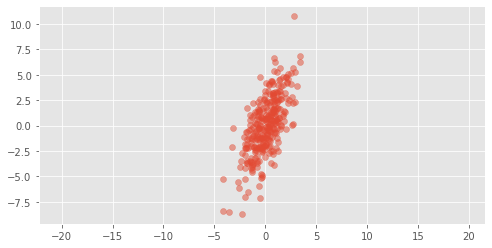

In [ ]:
fig, ax = plt.subplots(1, 1 , figsize = (8, 4))

mu = np.zeros(2)

C_angle = np.array([[2, 3], 
              [3, 9]])
#C_angle = np.array([[9, 3], 
#              [3, 2]])   

'''C_angle = np.array([[3, 3], 
                    [3, 6]])'''

data_angle = np.random.multivariate_normal(mu, C_angle, size=300)
ax.scatter(data_angle[:,0], data_angle[:,1], alpha=0.5)
plt.axis('equal')
plt.show()

Как мы знаем, теоретические истинные главные компоненты равны собственным векторам ковариационной матрицы. Давайте построим на наших графиках собственные вектора ковариационной матрицы и компоненты, которые нам выдаст в качестве своего ответа алгоритм PCA из библиотеки sklearn.

Для поиска собственных значений можно использовать функцию  
```python
np.linalg.eig(C)
```

См. https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html

Для PCA разложения функцию 
```python
sklearn.decomposition.PCA
```

**Внимание! Attention! Achtung!** 
* np.linalg.eig возвращает вторым значением матрицу собственных векторов, в которой собственные вектора расположены по столбцам, т.е. v\[:, i\] есть собственный вектор соответсвующий i-му собственному значению.
* В то же время в поле класса PCA PCA.components_ лежат вектора главных компонент, которые располагаются там построчно (n_components, n_features)

In [ ]:
import scipy
eigen_values_simple, eigen_vectors_simple = np.linalg.eig(C_simple)
eigen_values_angle, eigen_vectors_angle = np.linalg.eig(C_angle)

eigen_vectors_simple = eigen_vectors_simple.T
eigen_vectors_angle = eigen_vectors_angle.T

In [ ]:
eigen_values_simple

array([4., 2.])

In [ ]:
eigen_values_angle

array([ 0.89022777, 10.10977223])

In [ ]:
# PCA
pca_simple = sklearn.decomposition.PCA()
pca_simple.fit(data_simple)

pca_angle = sklearn.decomposition.PCA()
pca_angle.fit(data_angle)

# Let's compare it
print('simple PCA components:\n', pca_simple.components_)
print('simple true components:\n', eigen_vectors_simple)
print('*' * 80)
print('angle PCA components:\n', pca_angle.components_)
print('angle true components:\n', eigen_vectors_angle)


simple PCA components:
 [[-0.99999871 -0.00160892]
 [-0.00160892  0.99999871]]
simple true components:
 [[1. 0.]
 [0. 1.]]
********************************************************************************
angle PCA components:
 [[ 0.32699262  0.94502689]
 [-0.94502689  0.32699262]]
angle true components:
 [[-0.93788501  0.34694625]
 [-0.34694625 -0.93788501]]


Обратите внимание, что PCA упорядочивает собственные вектора. Это значит что собственный вектор соответствующий главной компоненте соответственно имеющей максимальную дисперсию будет находиться в первой строке. Этим объясняется разница вот второром случае.

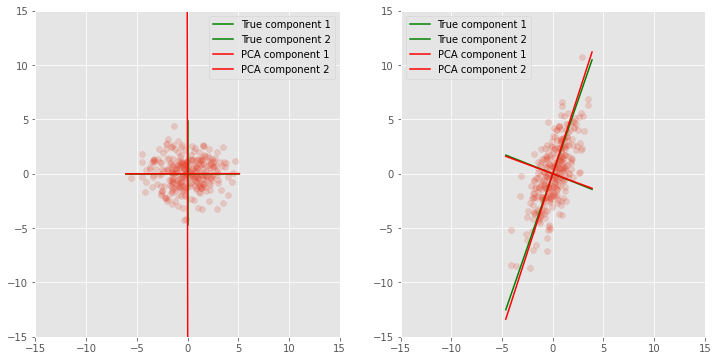

In [ ]:
# plot it
fig, (ax1, ax2) = plt.subplots(1, 2 , figsize = (12, 6))

ax1.scatter(data_simple[:,0], data_simple[:,1], alpha=0.2)
plot_components_vector(ax1, data_simple, eigen_vectors_simple[0], 'g', 'True component 1')
plot_components_vector(ax1, data_simple, eigen_vectors_simple[1], 'g', 'True component 2')

plot_components_vector(ax1, data_simple, pca_simple.components_[0], 'r', 'PCA component 1')
plot_components_vector(ax1, data_simple, pca_simple.components_[1], 'r', 'PCA component 2')

s=15; ax1.set(xlim=(-s, s), ylim=(-s, s))
ax1.legend()

ax2.scatter(data_angle[:,0], data_angle[:,1], alpha=0.2)
plot_components_vector(ax2, data_angle, eigen_vectors_angle[0], 'g', 'True component 1')
plot_components_vector(ax2, data_angle, eigen_vectors_angle[1], 'g', 'True component 2')

plot_components_vector(ax2, data_angle, pca_angle.components_[0], 'r', 'PCA component 1')
plot_components_vector(ax2, data_angle, pca_angle.components_[1], 'r', 'PCA component 2')
ax2.legend()
s=15; ax2.set(xlim=(-s, s), ylim=(-s, s))
plt.show()

Как вы видите зеленые компоненты (истинные главные компоненты) полученные разложением ковариационной матрицы на собственные вектора отличаются от красных компонент, которые были полученны вычислением PCA на данных. Это неудивительно, ибо данные были сгенерированы статистически. Если вы будете увеличивать размер сгенерированной выборки, то со временем разрешения экрана станет недостаточно для отображения разницы между PCA и реальными компонентами.

### Практика: explained variance ratio

В модуле PCA, после fit можно получить explained variance ratio посредством обращения к полю explained_variance_ratio_, а explined_variance посредством обращения к полю explained_variance_. 

Давайте на практике убедимся, что explained_variance соответсвует собственным значениям, а explained_variance_ratio соответствует долям соответствующих собственных значений от общей суммы собственных значений.

Для этого сгенерируем диагональную матрицу $ \Lambda $ с элементами на диагонале равными 1,2, 3, ... N и произвольную ортогональную матрицу $Q$. Введем новую матрицу $ A = Q \Lambda Q^T $. Можно доказать, что эта матрица симметрична и положительно определена, т.е. она является матрицей ковариаций. Сгенерируем данные по ней, применим к ней PCA разложение и посмотрим на explained_variance.

In [ ]:
from scipy.stats import ortho_group

dims = 5
Q = ortho_group.rvs(dims)
# check ortogonality
print(np.dot(Q, Q.T).round(8))

eig_vals = np.arange(1.0, dims + 1)
EV = np.diag(eig_vals)
# covariance matrix
CM = np.linalg.multi_dot([Q, EV, Q.T])
print(CM)

# check eigenvalues
print(np.linalg.eigvals(CM))

[[ 1.  0.  0. -0. -0.]
 [ 0.  1. -0.  0.  0.]
 [ 0. -0.  1.  0. -0.]
 [-0.  0.  0.  1.  0.]
 [-0.  0. -0.  0.  1.]]
[[ 2.59219433e+00 -5.83883073e-01 -8.12955508e-01  3.35963019e-01
   4.77260818e-01]
 [-5.83883073e-01  1.82529374e+00  5.32376990e-01 -5.15781345e-01
   6.43728581e-01]
 [-8.12955508e-01  5.32376990e-01  3.89533883e+00 -2.34251018e-01
   8.43964049e-01]
 [ 3.35963019e-01 -5.15781345e-01 -2.34251018e-01  4.14017345e+00
   2.34867472e-03]
 [ 4.77260818e-01  6.43728581e-01  8.43964049e-01  2.34867472e-03
   2.54699965e+00]]
[1. 5. 2. 3. 4.]


In [ ]:
data = np.random.multivariate_normal(np.zeros(dims), CM, size=50000)

pca = sklearn.decomposition.PCA()
pca.fit(data)
print('explained_variance_', np.sort(pca.explained_variance_).round(3))
print('eigen_values       ', eig_vals)
print('explained_variance_ratio_', np.sort(pca.explained_variance_ratio_).round(3))
print('eig_vals / sum(eig_vals) ', np.sort(eig_vals/np.sum(eig_vals)).round(3))

explained_variance_ [0.996 2.001 3.016 4.014 5.023]
eigen_values        [1. 2. 3. 4. 5.]
explained_variance_ratio_ [0.066 0.133 0.2   0.267 0.334]
eig_vals / sum(eig_vals)  [0.067 0.133 0.2   0.267 0.333]


### Пример с Титаником

Что бы понять как использовать PCA на практике найдем главные компоненты для датасета Titanic и посмотрим на какое распредилится между ними дисперсия.



[7.06176512e-01 2.84693357e-01 6.43277889e-03 9.96551891e-04
 4.60735277e-04 3.61596980e-04 2.84174996e-04 2.44317657e-04
 9.58340101e-05 6.78024243e-05 4.89086038e-05 4.53997411e-05
 3.47680426e-05 2.63259366e-05 1.32093618e-05 1.12352657e-05
 4.18460784e-06 1.48150864e-06 8.25811384e-07 4.05338795e-35
 1.76602190e-36]


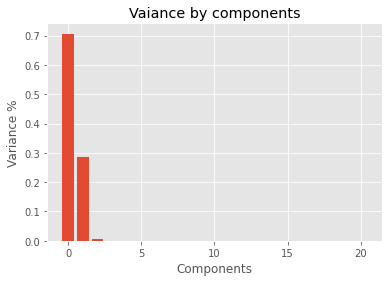

In [ ]:
titanic_pca = sklearn.decomposition.PCA()
titanic_pca.fit(X_train)
print(titanic_pca.explained_variance_ratio_)
#plt.bar(range(titanic_pca.explained_variance_.shape[0]),titanic_pca.explained_variance_)

plt.bar(range(titanic_pca.explained_variance_ratio_.shape[0]),titanic_pca.explained_variance_ratio_)
plt.title('Vaiance by components')
plt.xlabel('Components')
plt.ylabel('Variance %')
plt.show()

Как видно из графика большая часть дисперсии приходится на первые две компоненты. Можно предположить что остальные могут быть отброшенны без особого ушерба для точности модели.

In [ ]:
two_first_eigenvectors = titanic_pca.components_[:2]
X_train_reduced = np.dot(X_train,two_first_eigenvectors.T)
model = LogisticRegression()
model.fit(X_train_reduced,y_train)

X_test_reduced = np.dot(X_test,two_first_eigenvectors.T)
print(model.score(X_test_reduced,y_test))


0.664804469273743


Однако в данном случае это не так. Во первых потому что значительная часть данных бинарные. Во вторых вероятно присутствует одна из проблем, которые мы рассмотрим ниже.

### Пример с лицами

Рассмотрим как PCA применялся для решения практической задачи: распознавания лиц*.

Датасет:
[Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/)


* Сейчас для этого используются более эффективные алгоритмы использующие CNN.

Загрузим датасет и распакуем его на диск VM Colab

In [ ]:
# http://conradsanderson.id.au/lfwcrop/ (LFWcrop Face Dataset, greyscale version)
!wget http://conradsanderson.id.au/lfwcrop/lfwcrop_grey.zip

import matplotlib.pyplot as plt
import numpy as np
import os

dir='lfwcrop_grey/faces'

# http://conradsanderson.id.au/lfwcrop/ (LFWcrop Face Dataset, greyscale version)
!wget http://conradsanderson.id.au/lfwcrop/lfwcrop_grey.zip
!unzip lfwcrop_grey.zip


Streaming output truncated to the last 5000 lines.
  inflating: lfwcrop_grey/faces/Kaisser_Bazan_0001.pgm  
  inflating: lfwcrop_grey/faces/Tony_Blair_0113.pgm  
  inflating: lfwcrop_grey/faces/Paul_Coppin_0001.pgm  
  inflating: lfwcrop_grey/faces/Herta_Daeubler-Gmelin_0002.pgm  
  inflating: lfwcrop_grey/faces/Richard_Myers_0009.pgm  
  inflating: lfwcrop_grey/faces/Kaye_Young_0001.pgm  
  inflating: lfwcrop_grey/faces/Juan_Ignacio_Chela_0002.pgm  
  inflating: lfwcrop_grey/faces/Paul_Wollnough_0001.pgm  
  inflating: lfwcrop_grey/faces/Carolina_Moraes_0002.pgm  
  inflating: lfwcrop_grey/faces/Charles_Taylor_0007.pgm  
  inflating: lfwcrop_grey/faces/George_W_Bush_0006.pgm  
  inflating: lfwcrop_grey/faces/Ian_Gillan_0001.pgm  
  inflating: lfwcrop_grey/faces/Shaun_Pollock_0001.pgm  
  inflating: lfwcrop_grey/faces/Junichiro_Koizumi_0022.pgm  
  inflating: lfwcrop_grey/faces/Steve_Mariucci_0002.pgm  
  inflating: lfwcrop_grey/faces/George_W_Bush_0214.pgm  
  inflating: lfwcrop_grey/

(64, 64)


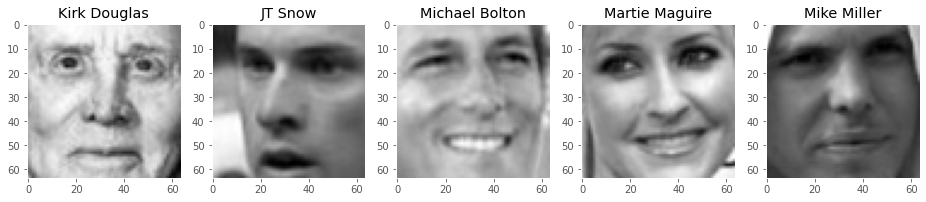

In [ ]:
plt.rcParams['axes.grid'] = False
def show_faces(images, titles, h=64, w=64):
    plt.figure(figsize=(16 , 4))
    for i in range(min(images.shape[0],5)):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i])
        

# Get first 1000 files
celebrity_photos=os.listdir(dir)[1:1001]
celebrity_images=[dir+'/' + photo for photo in celebrity_photos]
# Load iages from disk
images=np.array([plt.imread(image) for image in celebrity_images], dtype=np.float64)
# Extract real celebrity name from file name
celebrity_names=[name[:name.find('0')-1].replace("_", " ") for name in celebrity_photos]
print(images[0].shape)
show_faces(images, celebrity_names)

Предобработка данных:
Преобразуем изображения в вектора и центрируем их

(1000, 4096)


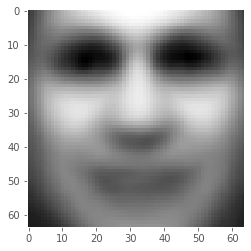

In [ ]:
# Stretch to vector
X = images.reshape(images.shape[0], 64*64)
print(X.shape)
mean = np.mean(X, axis=0)
# Center: substract mean
centered_faces = X-mean
plt.imshow(mean.reshape(64, 64), cmap=plt.cm.gray )

Найдем собственные вектора. Аналогия с фотороботом.

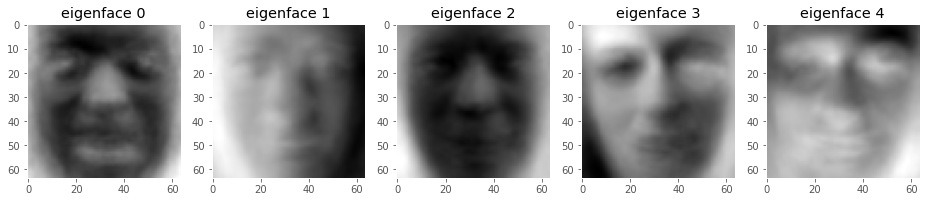

In [ ]:
import sklearn
from sklearn.decomposition import PCA
#https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
#n_components == min(n_samples, n_features)

pca_faces = sklearn.decomposition.PCA() #1000x4096

pca_faces.fit(centered_faces)
eigenfaces = pca_faces.components_
reshaped_eigenfaces = eigenfaces.reshape((1000, 64, 64))
eigenface_titles = ["eigenface %d" % i for i in range(reshaped_eigenfaces.shape[0])]
show_faces(reshaped_eigenfaces, eigenface_titles)


Восстановим лица с использованием n < 4096 компонент

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


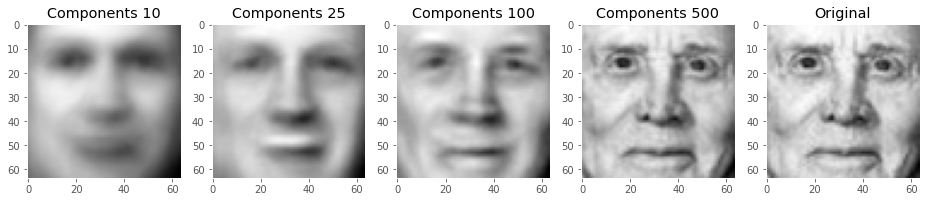

In [ ]:
def create_embedding(img, n_components):
  # Generate embedding for first image using only 10 first components
  img = img.reshape(64*64) - mean
  emb = np.dot(img,eigenfaces[:n_components].T) #(1,4096) * (4096,1) 
  #print(emb,emb.shape) # 10 - 500 numbers only!

  # Recover image from embeding
  recovered_img = np.dot(emb,eigenfaces[:n_components]) 
  recovered_img += mean #shift by mean
  return emb, recovered_img

# Shome images recovered from embeddings of various sizes 
original_image = images[0]
titles = []
img_list = []
for n in [10,25,100,500]:
  embedding, recovered = create_embedding(original_image, n)
  img_list.append(recovered)
  titles.append(f"Components {n}")
img_list.append(original_image)
titles.append("Original")

show_faces(np.array(img_list), titles)

Распознавание лиц.
Теперь сравнивая вектора признаки в пространстве размерности 300 или 500 можно построить систему распознавания лиц.



### Пратика: проблемы с PCA

Рассмотрим случай выборки, которая сгенерирована из двух вытянутых нормальных распределений, чьи основные оси неортогональны друг другу:

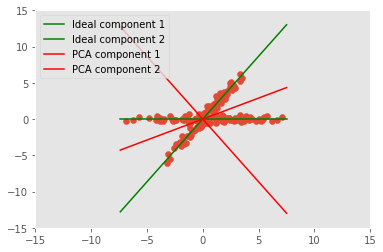

In [ ]:
C1 = np.array([[10,0],[0,0.1]])
# rotate second normal distrbution by 60 degrees
phi = np.pi/3
rotation = np.array([[np.cos(phi), np.sin(phi)],
                     [-np.sin(phi),np.cos(phi)]])

data_1 = np.random.multivariate_normal(mu, C1, size=100)
data_2 = np.dot(data_1, rotation)
# generate data from two not orthogonal distributions
data = np.vstack([data_1,
                  data_2])

fig, ax = plt.subplots(1)
# ax.axis('equal')
# ax.set_aspect('equal', 'box')
ax.scatter(data[:,0], data[:,1])

# plot real axis

plot_components_vector(ax, data, np.array([1, 0]), color="green", label="Ideal component 1")
plot_components_vector(ax, data, [np.cos(phi), np.sin(phi)], color="green", label="Ideal component 2")

# plot PCA
model = PCA(n_components=2)
model.fit(data)
W_pca = model.components_

plot_components_vector(ax, data, W_pca[0], color="red", label="PCA component 1")
plot_components_vector(ax, data, W_pca[1], color="red", label="PCA component 2")
s = C1[0, 0] * 1.5
ax.set(xlim=(-s, s), ylim=(-s, s))
# ax.set_aspect('equal', 'box')
plt.legend()
plt.draw()

In [ ]:
eigen_values, eigen_vectors = np.linalg.eig(np.cov(data, rowvar=False))
eigen_vectors

array([[ 0.86556628, -0.50079438],
       [ 0.50079438,  0.86556628]])

In [ ]:
W_pca

array([[-0.86556628, -0.50079438],
       [-0.50079438,  0.86556628]])

### Практика: еще одна проблема с PCA
Интересное направление в данных не совпадает с направлением максимальной дисперсии.

В примере ниже дисперсии не отражают интересующих нас направлений в данных:

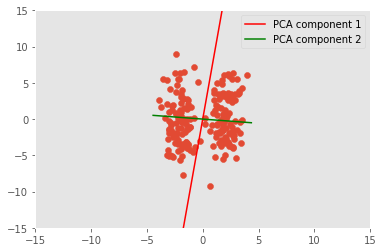

In [ ]:
C = np.array([[0.5,0],[0,10]])
mu1 = np.array([-2,0])
mu2 = np.array([2,0])

data = np.vstack([np.random.multivariate_normal(mu1, C, size=100),
                  np.random.multivariate_normal(mu2, C, size=100)])

fig, ax = plt.subplots(1)

ax.scatter(data[:,0], data[:,1])
# обучим модель pca и построим главные компоненты
model = PCA(n_components=2)
model.fit(data)

plot_components_vector(ax, data, model.components_[0], color="red", label="PCA component 1")
plot_components_vector(ax, data, model.components_[1], color="green", label="PCA component 2")

s = 15; ax.set(xlim=(-s, s), ylim=(-s, s))
ax.legend()
plt.show()

Очевидно, что в данном случае метод главных компонент будет считать вертикальную компоненту более значимой для описания набора данных, чем горизонтальную. 

Но, например, в случае, когда данные из левого и правого кластера относятся к разным классам, для их линейной разделимости вертикальная компонента является шумовой. Несмотря на это, её метод главных компонент никогда шумовой не признает, и есть вероятность, что отбор признаков с его помощью выкинет из ваших данных значимые для решаемой вами задачи компоненты просто потому, что вдоль них значения имеют низкую дисперсию.

Справляться с такими ситуациями могут некоторые другие методы уменьшения размерности данных, например, метод независимых компонент (Independent Component Analysis, ICA).

### Недостатки линейного PCA

Как мы увидели в предыдущих примерах, обычный PCA далеко не всегда работает хорошо. В частности, могут быть ситуации, когда построенная PCA проекция не дает хорошего разбиения объектов на группы. Для набора картинок с написанными от руки цифрами  MNIST, PCA даст такой результат:

Также бывают ситуации, когда оптимально спроецировать не на некоторую плоскость, а на многообразие (кривая плосоксть), как показано на картинке ниже.

<img src="http://edunet.kea.su/repo/src/L04_Feature_Engineering/img/S-manifold.png" width=600/>


В данном случае оптимально спроецировать на S-образную кривую. 

В связи с вышеописанными случаями, ниже мы рассмотрим более сильные методы.

## Kernel PCA Ядровой (нелинейный) метод главных компонент

Как уже упомяналось, иногда невозможно захватить всю информацию линейной проекцией, хотя кривая поверхность с такой же размерностью это позволяет сделать. Одним из подходов к решению данной проблемы является задача перевода признаков в нелинейное пространство. 

### Kernel trick


Kernel Trick избегает явного отображения, которое нужно для получения линейного обучающего алгоритма для нелинейной функции или границы решений. Для всех $\mathbf{x} \ и \ \mathbf{{x}'} $ во входном пространстве $ \mathcal {X} $ некоторые функции $ k(\mathbf {x} ,\mathbf {x'}) \colon   \mathcal {X} \times \mathcal {X}\to \mathbb {R}$ )  могут быть представлены как скалярное произведение в другом пространстве $ \mathcal  {V} $. 
То есть, $ k(\mathbf {x} ,\mathbf {x'}) = < \phi(\mathbf{x}), \phi(\mathbf{x'})>$, где $ \phi \colon {\mathcal {X}}\to {\mathcal {V}} $, некоторая функция перевода функций из одного пространства в другое.


Функцию $k(\mathbf {x} ,\mathbf {x'})$ часто называют *ядром или ядерной функцией (kernel, kernel function)*, а пространство V - *спрямляющим пространством*.



Картинка с проекцией в более высокоразмерное пространство. 

После этого мы можем использовать обычный линейный PCA, но в высокоразмерном пространстве.

В новом более высокоразмерном пространстве нам не нужно делать никаких вычислений (нужно вычислять только скалярные произведения).

https://www.youtube.com/watch?v=HbDHohXPLnU&ab_channel=caltech


Пример с разделением MNIST
Пример с разделением radial kernel

PCA довольно чувствителен к выбору ядра.

К примеру, для данных, расположенных на трех окружностях:

<img src="http://edunet.kea.su/repo/src/L04_Feature_Engineering/img/L04_PCA-3-circles.png" width=260/>


в зависимости от выбора ядра мы будем получать совершенно разные отображение в спрямляющее пространство:


<img src="http://edunet.kea.su/repo/src/L04_Feature_Engineering/img/L04_PCA-kernels.png" width=600/>


Упомянуть про размерности

Типы ядер:
Картинка из ESL (p 549)
Гауссово (см видео)

* $k(x_i, x_j) = \frac{1}{z} e^{-\frac{h(x_i, x_j)^2}{h}}$ - радиальная базисная функция RBF
* $k(x_i, x_j) = (<x_i, x_j> + c)^d, с, d \in \mathbb{R}$ - полиномиальное ядро
* $k(x_i, x_j) = \sigma((x_i, x_j>)$ - ядро с функцией активации

Интуиция: точки, лежащие рядом друг с другом в исходном пространстве, должны иметь большие скалярные произведения
(картинка с Гауссианой).


В целом, нелинейные методы требуют больше данных как более гибкие алгоритмы. Поэтому лучше начинать с линейных и переходить к нелинейным только тогда, когда они действительно необходимы.

Примеры
https://scikit-learn.org/stable/auto_examples/decomposition/plot_kernel_pca.html


## Другие методы

Существуют и другие, более сильные методы понижения размерности в данных. К примеру, t-SNE и UMAP. Мы не будем на них подробно останавливаться. Просто сравните картинки, проекций MNIST, полученные с помощью PCA, t-SNE и UMAP. А также сравните время работы, затраченное на каждый из этих методов.




## tSNE (t-distributed stochastic neighbor embedding)


Идея состоит не в том что бы напрямую максимизировать дисперсиию, а найти такое пространство в котором расстояние между объектами будет сохраняться или по крайне мерее не сильно менятся.


<img src="http://edunet.kea.su/repo/src/L04_Feature_Engineering/img/L04_manifold.jpg" >


<img src="http://edunet.kea.su/repo/src/L04_Feature_Engineering/img/L04_t-SNE.png" >


http://datareview.info/article/algoritm-t-sne-illyustrirovannyiy-vvodnyiy-kurs/

 При уменьшении размерности набора данных, если использовать гауссово распределение для точек данных и точек отображения, мы получим дисбаланс в распределении расстояний для соседей точек. Это объясняется тем, что распределение расстояний существенно отличается для пространства большой размерности и для пространства малой размерности.

## UMAP
UMAP — uniform manifold approximation and projection
https://www.youtube.com/watch?v=94ZMJ8tq1Wk
https://umap-learn.readthedocs.io/en/latest/how_umap_works.html


Local connection assumption:

 
Картинки с примерами разделений плоскости на PCA, t-SNE, UMAP


<img src="http://edunet.kea.su/repo/src/L04_Feature_Engineering/img/L04_MNIST.jpg" >


UMAP builds mathematical theory to justify the graph based approach

UMAP understands the distance is involved we have obtained all the internal structure of these clusters and the global structure as well (пример test и trin set UMAP)


### t-SNE vs UMAP

As the size of a dataset increases the runtime of a given dimension reduction algorithm will increase at varying rates. If you ever want to run your algorithm on larger datasets you will care not just about the comparative runtime on a single small dataset, but how the performance scales out as you move to larger datasets. We can similate this by subsampling from MNIST digits (via scikit-learn’s convenient resample utility) and looking at the runtime for varying sized subsamples. Since there is some randomness involved here (both in the subsample selection, and in some of the algorithms which have stochastic aspects) we will want to run a few examples for each dataset size. We can easily package all of this up in a simple function that will return a convenient pandas dataframe of dataset sizes and runtimes given an algorithm.


<img src="http://edunet.kea.su/repo/src/L04_Feature_Engineering/img/UMAP-TSNE-performance.png" width=450/>

Here we see UMAP’s advantages over t-SNE really coming to the forefront. While UMAP is clearly slower than PCA, its scaling performance is dramatically better than MulticoreTSNE, and, despite the impressive scaling performance of openTSNE, UMAP continues to outperform it. Based on the slopes of the lines, for even larger datasets the difference between UMAP and t-SNE is only going to grow.

This concludes our look at scaling by dataset size. The short summary is that PCA is far and away the fastest option, but you are potentially giving up a lot for that speed. UMAP, while not competitive with PCA, is clearly the next best option in terms of performance among the implementations explored here. Given the quality of results that UMAP can provide we feel it is clearly a good option for dimension reduction.


Более подробно: https://umap-learn.readthedocs.io/en/latest/performance.html

In [ ]:
from sklearn import manifold, datasets
from matplotlib import offsetbox

digits = datasets.load_digits(n_class=10)
X = digits.data
y = digits.target
n_samples, n_features = X.shape

def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)


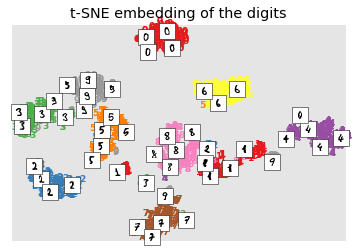

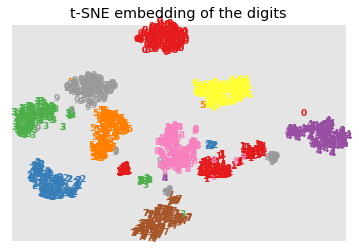

In [ ]:
# t-SNE embedding of the digits dataset
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X)
plot_embedding(X_tsne, "t-SNE embedding of the digits")

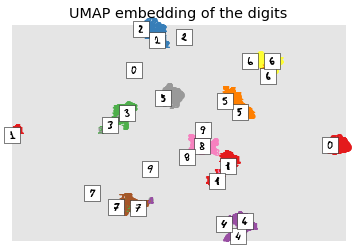

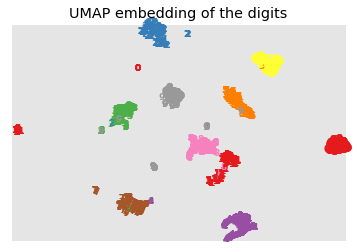

In [ ]:
import umap

umap = umap.UMAP(n_neighbors=5)
X_umap = umap.fit_transform(X) # преобразовываем
plot_embedding(X_umap, "UMAP embedding of the digits")

## Визуализация

Оба метода применяются в основном не для предобработки данных, а для визуализации.

In [ ]:
# Примеры

from torch.utils.tensorboard import SummaryWriter
import numpy
import torchvision

mnist = torchvision.datasets.MNIST('mnist', train = False, download = True)
#train_set.datanumpy()
print(mnist.data.shape)


In [ ]:
# Вспомогательный метод для запуска Tensorboard в Colab

# Fix https://stackoverflow.com/questions/60730544/tensorboard-colab-tensorflow-api-v1-io-gfile-has-no-attribute-get-filesystem
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

import os
import torch
# Запуск Tensorboard в Colab
def reinit_tensorboard(clear_log = True):
  # Лог-файлы читаются из этого каталога: 
  logs_base_dir = "runs"
  if clear_log:
    # Очистка логов
    !rm -rfv {logs_base_dir}/*
    os.makedirs(logs_base_dir, exist_ok=True)
  # Магия Colab
  %load_ext tensorboard
  %tensorboard --logdir {logs_base_dir}

#, metadata=mnist.targets
reinit_tensorboard()
mnist_chunk = mnist.data[:1000]
writer = SummaryWriter(comment = "mnist")
writer.add_embedding(torch.reshape(mnist_chunk,(-1,28*28)),mnist.targets[:1000])
writer.close()